#Summarization

- Summarization is a classic squence-to-sequence(seq2seq) task with an input text and a target text.

In [1]:
!pip install datasets transformers torch accelerate sentencepiece -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.9 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

dataset=load_dataset('cnn_dailymail',version='3.0.0')
print(f'Features:{dataset["train"].column_names}')

Features:['article', 'highlights', 'id']


In [3]:
sample=dataset['train'][1]

In [4]:
print(
    f"Article (excerpt of 500 characters, total_length:{len(sample['article'])});"
      )
print(sample['article'][:500])
print(f"\nSummary (length:{len(sample['highlights'])})")
print(sample['highlights'])


Article (excerpt of 500 characters, total_length:4051);
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

Summary (length:281)
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


- Main issue here is, most transformer model have the context size usually limited to 1000 tokens or so, which is eequivalent to a few paragrahps of text.

- The standard, yet crude way to deeal with this is fro summarization is to simply truncate the text beyond  the models context size





In [5]:
sample_text=dataset['train'][1]['article'][:200]
summaries={}


- A convention in summarization is to separete the summary sentences by a newline
- We could add a newline token after each full stop, but this simple heuristic woudl fail for strings like "U.S." or "U.N."
- The NLTK includes more sophisticated algorithm that can differentiate  the end of a sentence from puntuation that occurs in abbreviations:

In [6]:
!pip install nltk -q

In [7]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')
string="The U.S. are a country. The U.N. is an organization"
sent_tokenize(string)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['The U.S. are a country.', 'The U.N. is an organization']

## Summarization Baseline

- A common baseline for summariszing news articles is to simply take the first three sentences of the article

- With NLTK's sentence tokenizer, we can easily implement such as baseline:

In [8]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

    summaries['baseline']=three_sentence_summary(sample_text)

In [9]:
from transformers import pipeline, set_seed

set_seed(42)
pipe=pipeline('text-generation',model='gpt2-xl')


In [10]:
gpt2_query=sample_text+"\nTL;DR:\n"
pipe_out=pipe(gpt2_query,max_length=512,clean_up_tokenization_spaces=True)
summaries['gpt2']="\n".join(
    sent_tokenize(pipe_out[0]['generated_text'][len(gpt2_query) :])
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


- Here we store the summaries of text by slicing off the input query and keep the result in dictionary

# T5
- The creatores of this model performed a comprehensive study of transfer learning in NLP and found they could create a universal transformer architecture by formulating all tasks as text-to-text tasks.

- The T5 checkpoints are trained on a mixture of unsupervivsed data( to reconstruct masked words) and supervised data for several tasks, including summarization.



In [11]:
pipe=pipeline('summarization',model='t5-large')
pipe_out=pipe(sample_text)
summaries['t5']='\n'.join(sent_tokenize(pipe_out[0]['summary_text']))

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Your max_length is set to 200, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_leng

In [12]:
# BART also uses encoder-decoder architecture and is trained on to reconstruct corrupted inbuts
# It combines the pretraining schemes of BERT and GPT-2

In [13]:
pipe=pipeline('summarization',model='facebook/bart-large-cnn')
pipe_out=pipe(sample_text)
summaries['bart']="\n".join(sent_tokenize(pipe_out[0]['summary_text']))

Your max_length is set to 142, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


In [14]:
pipe=pipeline('summarization',model='google/pegasus-cnn_dailymail')
pipe_out=pipe(sample_text)
summaries['pegasus']=pipe_out[0]['summary_text'].replace(" .<n>",".\n")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Your max_length is set to 128, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


In [15]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

GPT2
I'm not an expert on law, but I'm doing the best I can and trying to be honest and accurate.
Why is this such a big deal?
Because we, as human beings, are designed to find fault and blame.
We are built to do that.
My argument is that the more we do that, the more likely our legal system is to fall apart.
We're constantly trying to make excuses and finding excuses and getting angry at others.
But the bigger problem is that those who would criticize us -- we, the media, the people who make it possible for us to do our job -- are the ones doing it.
They are the ones who have the power and the ability to point that finger.
How many other problems in our country -- problems we can easily point a

- Often GPT-2 model hallucinates or invetns facts since it was not explicitly trained to generate truthful summaries

# Measuring the Quality of Generated Text

- Measuring performance on a text generation task is not as easy as with standard classification tasks such as sentiment analysis or named entity recognition

- Two of the most common metrics used to evaluate generated text are
BLEU, and ROUGE



### **BLEU**
- Instead of looking at how many of the tokens in the generated texts are perfectly aligned with the reference text tokens, we lookk at words or n-grams.
- BLEU is a precision-based metric, whcih means that when we compare thee two texts we count the number o words in the genereation that occur in the reference and divide it by the length of the generation

- However, there is an issue with this vanilla precision
    - Assume the generated text just repeats the same word over and over again, and this word also appers in the reference.
    - If it is repeated as many times as the lenght of the reference text, the we get perfect precision

    - For this reason, there is slight modification
        - Word is only counted as many times as it occurs in the reference.
        - The precision score favours the short generations
        - To compensate that the brevity penalty is introduced:

        BR=min(1,e^10kref^\lgen)
         - By taking the minimum, we ensure that htis penalty never exceeds 1 and the exponential term becomes exponentially small when the length of the generaed text l_gen is smalled than the reference text l_ref.

        - Why we dont use a F1 score instead?,
            - often in tranlation datasets there are multiple refernece sentences instead of just one, so ifwe also measured recall we would incentive translations that used all the words from the refreces
            - Thus it is preferable to lok for high preicsion in the tranlation and make sure th tranlation and reference have a similar length

        - Final Format: BLEU-N=BR x (Πᴺₙ=1Pₙ)^1/ᴺ


## **LIMITATIONS**
- It doesn't take synonyms into account, and many steps in the derivation seem like ad hoc and rather fragile heuristics
- Expects the text to already be tokenized.
    - SOLUTION: SACREBBLEU


In [17]:
!pip install sacrebleu -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 2.5 MB/s eta 0:00:00


In [18]:
from datasets import load_metric
bleu_metric=load_metric('sacrebleu')

In [21]:
import pandas as pd
import numpy as np
bleu_metric.add(
    prediction='the the the the the the',reference=['the cat is on the mat']
)
results=bleu_metric.compute(smooth_method='floor',smooth_value=0)
results['precisions']=[np.round(p,2) for p in results['precisions']]
pd.DataFrame.from_dict(results,orient='index',columns=['Value'])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


- BLEU score is widely used for evaluating text especially in machine translation since precise translations are usually favored over translations that incldue all possible and appropriate words

There are other applications such as summarization, where the situation is different,

- There we want all the important information in the generaed text, so we favour high recall, this where ROUGE score is usually used

### ROGUE

- Spefically developed for applications like summarization where high recall is more important than just preciison.
- Approach is similar to bLEU score in that we look at different n-grams and compare their occurecnes in the generated text and the refernce text


- The difference is that with ROUGE we check how many n-grams in the reference text also occur in the generated text

    - For BLEU we looked at hwo many n-grams in the generated text appear in the reference, so wenca reuse the preccision formula with minor modification that we count the(unclipped) occurence of reference n-grams in the generated text in the denominator

    - Without clipping the counting we can measure precision as well, adn we can the n combine both precision and recall ROUGE scores in the harmonic mean to get an F1-score: ROUGE

    - This is a separete score in ROUGE to measure the longes common string(LCS), called ROUGE-L.

    - LCS can be calculated for any string, ex: "abab" and "abc" would be "ab" and its length would be 2

    - if we want to compare this value between two samples we need to somehow normalize iot beause otherwise a longer text would be at an advantage

    - To achieve this, the inventor of ROUGE, come up with an F-score like scheme where theLCS is normalized with the length of the reference and generated text, then the wo normalized scores are mixed together

In [23]:
!pip install rouge_score -q

  Preparing metadata (setup.py) ... done


In [24]:
rouge_metric=load_metric('rouge')

In [27]:
reference=dataset['train'][1]['highlights']
records=[]
rouge_names=['rouge1','rouge2','rougeL','rougeLsum']

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name],reference=reference)
    score=rouge_metric.compute()
    rouge_dict=dict((rn,score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)

pd.DataFrame.from_records(records,index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
gpt2,0.085779,0.004535,0.054176,0.085779
t5,0.162162,0.000000,0.108108,0.135135
bart,0.191489,0.000000,0.127660,0.191489
pegasus,0.200000,0.000000,0.114286,0.200000


In [28]:
def evaluate_summaries_baseline(dataset,metric,column_text='article',column_summary='highlights'):
    summaries=[three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,references=dataset[column_summary])
    score=metric.compute()
    return score

In [29]:
test_sampled=dataset['test'].shuffle(seed=42).select(range(1000))

score=evaluate_summaries_baseline(test_sampled,rouge_metric)
rouge_dict=dict((rn,score[rn].mid.fmeasure)for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict,orient='index',columns=['baseline']).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.389276,0.171296,0.245061,0.354239


In [30]:
from tqdm import tqdm
import torch

device='cuda' if torch.cuda.is_available() else 'cpu'
def chunks(list_of_elements,batch_size):
    """Yield sucessive batch-sized chunks from list of elements"""
    for i in range(0, len(list_of_elements),batch_size):
        yield list_of_elements[i :i+ batch_size]

def evaluate_summaries_pegasus(dataset,metric,model,tokenizer,batch_size=16,device=device,column_text='article',column_summary='highlights'):
    article_batches=list(chunks(dataset[column_text],batch_size))
    target_batches=list(chunks(dataset[column_summary],batch_size))

    for article_batch,target_batch in tqdm(zip(article_batches,target_batches),total=len(article_batches)):
        inputs=tokenizer(article_batch,max_length=1024,truncation=True,padding='max_length',return_tensors='pt')

        summaries=model.generate(input_ids=inputs['input_ids'].to(device),
                                  attention_mask=inputs['attention_mask'].to(device),
                                  length_penalty=.8,num_beams=8,max_length=128
                                  )
        decoded_summaries=[tokenizer.decode(s,skip_special_tokens=True,clean_up_tokenization_spaces=True) for s in summaries]
        decoded_summaries=[d.replace("<n>"," ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries,references=target_batch)

        score=metric.compute()

        return score



1.   First we split the dataset into smaller batches that we can process simultaneously.
2.   Then for each batch we tokenize the input articles and feed them to the genereate() function to produce the summaries using beam search.
3.  We use the same generations parameters as propsosed in the paper
the new paramreter for length penalty ensure tha the model does not generate sequences that are too long.
4. Finally we decode the generated texts, replace the <n> token, and add the decoded texts with the references to the metric

5. At the end we compute and return the ROUGE scores.


In [32]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
model_ckpt='google/pegasus-cnn_dailymail'
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)
model=AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score=evaluate_summaries_pegasus(test_sampled,rouge_metric,model,tokenizer,batch_size=8)
rouge_dict=dict((rn,score[rn].mid.fmeasure) for rn in rouge_names)

pd.DataFrame(rouge_dict,index=['pegasus'])

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/125 [00:49<?, ?it/s]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.389936,0.149829,0.263226,0.321016


In [34]:
!pip install py7zr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.7 MB/s eta 0:00:00


In [35]:
dataset_samsum=load_dataset('samsum')
split_lengths=[len(dataset_samsum[split])for split in dataset_samsum]

print(f"Split Lengths:{split_lengths}")
print(f"Feautess:{dataset_samsum['train'].column_names}")
print(f"\n Dialogue:")
print(dataset_samsum['test'][0]['dialogue'])

print(f"\n Summary:")
print(dataset_samsum['test'][0]['summary'])


Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Split Lengths:[14732, 819, 818]
Feautess:['id', 'dialogue', 'summary']

 Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

 Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [36]:
pipe_out=pipe(dataset_samsum['test'][0]['dialogue'])
print('Summary:')
print(pipe_out[0]['summary_text'].replace(" .<n>",".\n"))

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [38]:
score=evaluate_summaries_pegasus(dataset_samsum['test'],rouge_metric,model,tokenizer,column_text='dialogue',column_summary='summary',batch_size=8)

rouge_dict=dict((rn,score[rn].mid.fmeasure)for rn in rouge_names)
pd.DataFrame(rouge_dict,index=['pegasus'])

  0%|          | 0/103 [00:48<?, ?it/s]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.267117,0.060507,0.196581,0.196891


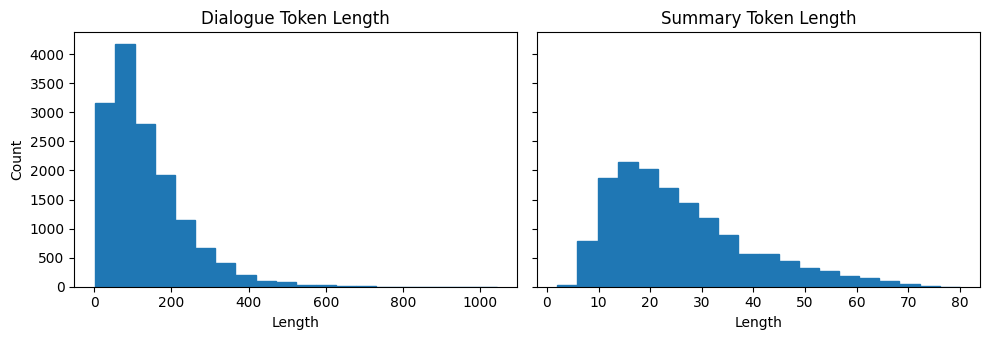

In [40]:
import matplotlib.pyplot as plt
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [41]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
                                     truncation=True)

    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [42]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)


In [47]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)


In [48]:
from huggingface_hub import notebook_login

notebook_login()

In [49]:
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

In [50]:
trainer.train()
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary")

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

Step,Training Loss,Validation Loss
500,1.677700,1.484984


  0%|          | 0/410 [00:07<?, ?it/s]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.368132,0.104054,0.320513,0.320513


- Since the model is quite big, we had to set the batch size to 1
- however a batch size that size that is too small can hurt convergence
- To resolve tht issue, we can use a nifty technique called gradient accumulation
- As the name suggest instead of calculating the gradients of the full batch all at once, we make smaller batches and aggregate the gradietns
- When we have aggregated enough gradients, we run the optimization step
- Naturally this is a bit slower than doing it in one pass, but it saves us a lot of GPU memory

In [51]:

# hide_input
pd.DataFrame(rouge_dict, index=[f"pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.368132,0.104054,0.320513,0.320513


In [52]:
trainer.push_to_hub("Training complete!")

training_args.bin:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

'https://huggingface.co/ckandemir/pegasus-samsum/tree/main/'